In [1]:
%matplotlib inline
%mkdir figures
from load_data import load_heart_disease, load_diabetes
from datetime import datetime
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Clustering algos
from sklearn.cluster import KMeans, FeatureAgglomeration
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

from sklearn.neural_network import MLPClassifier

seed = 1
np.random.seed(seed)
test_ratio = .2

dset = "db"
save_dir = "figures"
x, y = load_diabetes()
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=test_ratio, stratify=y, random_state=seed)
validation_splits = 5
kf = KFold(n_splits=validation_splits)
def r_err(y_te, y_pred): # return error
    return round(1 - accuracy_score(y_te, y_pred), 3)

mkdir: cannot create directory ‘figures’: File exists


In [2]:
# Clustering Hyperparams
cluster_range = range(2,9)

# KMeans
kmeans_models = [KMeans(n_clusters=i, random_state=seed).fit(x) for i in cluster_range]
kmeans_labels = [model.labels_ for model in kmeans_models]
kmeans_centers = [model.cluster_centers_ for model in kmeans_models]

# EM
em_models = [GaussianMixture(n_components=i, random_state=seed).fit(x) for i in cluster_range]
em_labels = [model.predict(x) for model in em_models]
em_centers = [model.means_ for model in em_models]
for model in em_models: # Are the models converged?
    print(model.converged_)

True
True
True
True
True
True
True


In [3]:
# Project clustering down to two components for visualization
pca = PCA(n_components=2, random_state=seed)
pca.fit(x)
projected_data = pca.transform(x)

projected_kmeans_centers = []
for center_list in kmeans_centers:
    projected_kmeans_centers.append(pca.transform(center_list))
    
projected_em_centers = []
for center_list in em_centers:
    projected_em_centers.append(pca.transform(center_list))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


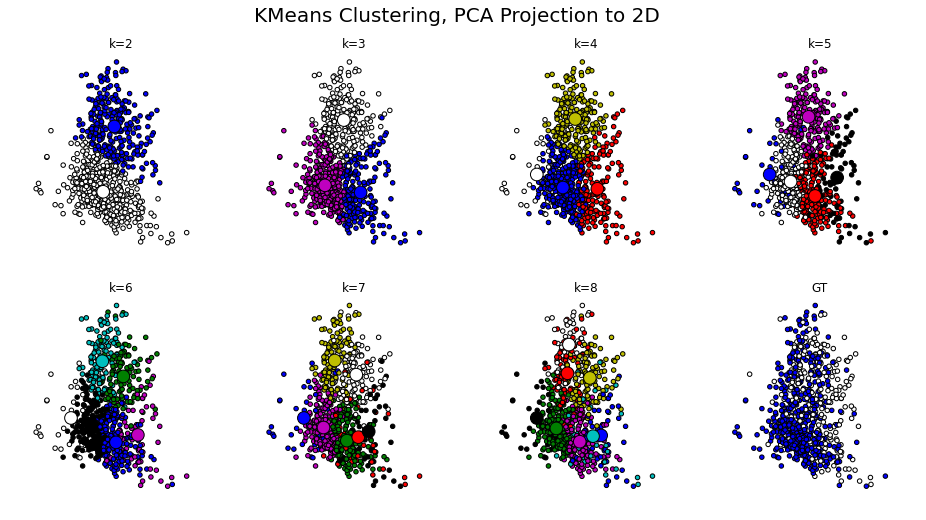

In [4]:
colors = ['b','g','r','c','m','y','k','w']
fig, axes = plt.subplots(2,4, figsize=(16,8))
axes = axes.reshape(-1)
for i in range(len(kmeans_labels)):
    ax = axes[i]
    ax.set_axis_off()
    ax.scatter(projected_data[:,0], projected_data[:,1], c=kmeans_labels[i], cmap=matplotlib.colors.ListedColormap(colors))
    ax.scatter(projected_kmeans_centers[i][:,0], projected_kmeans_centers[i][:,1], s=160, c=np.arange(i+2), cmap=matplotlib.colors.ListedColormap(colors))
    ax.set_title("k={}".format(i+2))
axes[-1].scatter(projected_data[:,0], projected_data[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
axes[-1].get_xaxis().set_ticks([])
axes[-1].get_yaxis().set_ticks([])
axes[-1].set_title("GT")
axes[-1].set_axis_off()
fig.suptitle("KMeans Clustering, PCA Projection to 2D", size=20)
fig.savefig("{}/{}_kmeans_proj.png".format(save_dir, dset))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


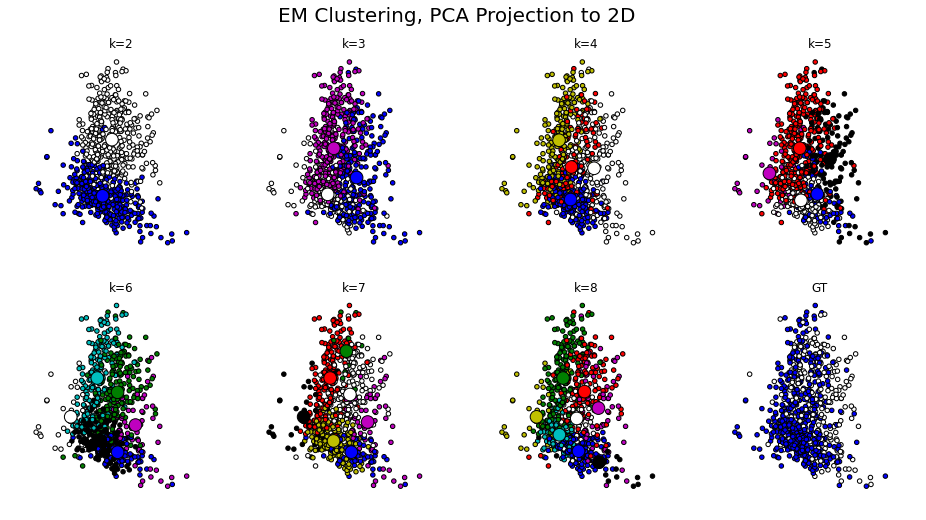

In [5]:
fig, axes = plt.subplots(2,4, figsize=(16,8))
axes = axes.reshape(-1)
for i in range(len(em_labels)):
    ax = axes[i]
    ax.set_axis_off()
    ax.scatter(projected_data[:,0], projected_data[:,1], c=em_labels[i], cmap=matplotlib.colors.ListedColormap(colors))
    ax.scatter(projected_em_centers[i][:,0], projected_em_centers[i][:,1], s=160, c=np.arange(i+2), cmap=matplotlib.colors.ListedColormap(colors))
    ax.set_title("k={}".format(i+2))
axes[-1].scatter(projected_data[:,0], projected_data[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
axes[-1].get_xaxis().set_ticks([])
axes[-1].get_yaxis().set_ticks([])
axes[-1].set_title("GT")
axes[-1].set_axis_off()
fig.suptitle("EM Clustering, PCA Projection to 2D", size=20)
fig.savefig("{}/{}_em_proj.png".format(save_dir, dset))

KMeans Homogeneity: 0.06223149364840771, Completeness: 0.06283861520317906, V Measure: 0.06253358086594102
EM Homogeneity: 0.051824892622500084, Completeness: 0.05550061932190485, V Measure: 0.05359981209928754


/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


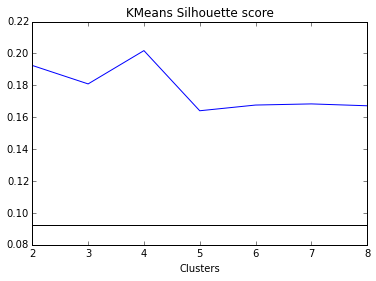

In [6]:
# Other metrics for analyzing clustering
import sklearn.metrics as metrics

# Note that since completeness depends on binary label, it naturally goes down - makes sense that mutual info is bad for higher ranges
# Note the separation of cluster and label (in general, but not for labelled metrics)
# Homogeneity can be done for k != 2 clusters
v_measure_means = metrics.homogeneity_completeness_v_measure(kmeans_labels[0], y)
v_measure_em = metrics.homogeneity_completeness_v_measure(em_labels[0], y)
print("KMeans Homogeneity: {}, Completeness: {}, V Measure: {}".format(v_measure_means[0], v_measure_means[1], v_measure_means[2]))
print("EM Homogeneity: {}, Completeness: {}, V Measure: {}".format(v_measure_em[0], v_measure_em[1], v_measure_em[2]))
kmeans_silhouettes = []
em_silhouettes = []
for i in range(len(kmeans_labels)):
    kmeans_silhouettes.append(metrics.silhouette_score(x, kmeans_labels[i], metric='euclidean'))
    em_silhouettes.append(metrics.silhouette_score(x, em_labels[i], metric='euclidean'))
true_silhouette = metrics.silhouette_score(x,y,metric='euclidean')
plt.plot(kmeans_silhouettes)
plt.hlines(true_silhouette,0,len(kmeans_labels) - 1)
plt.xlabel("Clusters")
plt.xticks(range(len(cluster_range)), cluster_range)
# plt.yticks([])
plt.title("KMeans Silhouette score")
plt.savefig("{}/{}_kmeans_silhouette.png".format(save_dir, dset))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


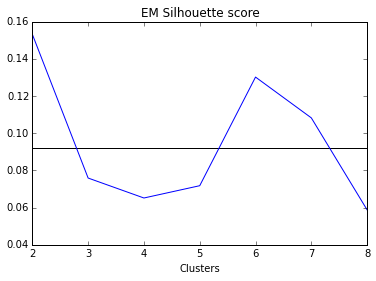

In [7]:
plt.plot(em_silhouettes)
plt.hlines(true_silhouette,0,len(em_labels) - 1)
plt.xlabel("Clusters")
plt.xticks(range(len(cluster_range)), cluster_range)
# plt.yticks([])
plt.title("EM Silhouette score")
plt.savefig("{}/{}_em_silhouette.png".format(save_dir, dset))

In [8]:
# Part two: Just reduce the dimensions
# Project clustering down to two components for visualization
dim_red = {}
dim_red['pca'] = []
dim_red['ica'] = []
dim_red['ran'] = []
dim_red['agg'] = []

# 2, 3, 4, 5 - since diabetes only has around 8 features
num_features = range(2,6)
models = {}
models['pca'] = []
models['ica'] = []
models['ran'] = []
models['agg'] = []
for i in num_features:
    for red in dim_red:
        if red == 'pca':
            method = PCA(n_components=i, random_state=seed)
        elif red == 'ica':
            method = FastICA(n_components=i, random_state=seed)
        elif red == 'ran':
            method = GaussianRandomProjection(n_components=i, random_state=seed)
        elif red == 'agg':
            method = FeatureAgglomeration(n_clusters=i)
        method.fit(x)
        models[red].append(method)
        dim_red[red].append(method.transform(x))
    

[[5.83842834 1.72899475 3.49978976]
 [4.12092973 2.15787145 1.33777754]
 [4.23178303 3.19415841 0.87720513]
 [2.47441757 2.37774225 2.75894613]]


/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


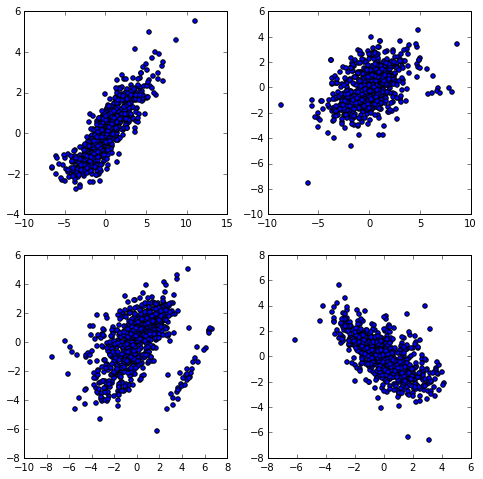

In [9]:
# Run random in its own route several times
random_var = []
fig, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.reshape(-1)
for i in range(4):
    method = GaussianRandomProjection(n_components=3, random_state=i)
    method.fit(x)
    data = method.transform(x)
    random_var.append(np.var(data, axis=0))
    axes[i].scatter(data[:,0], data[:,1])
print(np.array(random_var))
plt.savefig("{}/{}_random_proj.png".format(save_dir, dset))    

In [10]:
from scipy.stats import skew, kurtosis
stats = {}
stats['var'] = {}
stats['skew'] = {}
stats['kur'] = {}
# Best shown in tabular data
for i, red, in enumerate(dim_red):
    for stat in stats:
        stats[stat][red] = []
    for j, projection in enumerate(dim_red[red]):
        stats['var'][red].append(np.around(np.var(projection, axis=0), 5))
        stats['skew'][red].append(np.around(skew(projection, axis=0), 5))
        stats['kur'][red].append(np.around(kurtosis(projection, axis=0), 5))
for stat in stats:
    for red in stats[stat]:
        for j in range(len(stats[stat][red])):
            print("{}:{}:{}d - {}".format(stat, red, j + 2, stats[stat][red][j]))
# Note ICA identical variance and PCA decreasing variance
# Rnadom Projection has greater variance?
# Aggregation shows mountain shape

kur:ica:2d - [ 0.9914  -0.59068]
kur:ica:3d - [-0.55937  2.55618  3.39209]
kur:ica:4d - [ 5.19938 -0.55717  2.63574  2.83799]
kur:ica:5d - [ 5.48942  2.66618 -0.6051   4.01991 -0.55191]
kur:agg:2d - [ 1.31782 -0.55996]
kur:agg:3d - [ 1.7959  -0.55996  1.9639 ]
kur:agg:4d - [ 1.9639  -0.55996  0.51086  5.54917]
kur:agg:5d - [ 4.59864 -0.55996  0.51086  5.54917  0.631  ]
kur:pca:2d - [ 0.84464 -0.50225]
kur:pca:3d - [ 0.84464 -0.50225  1.27468]
kur:pca:4d - [ 0.84464 -0.50225  1.27468  2.06737]
kur:pca:5d - [ 0.84464 -0.50225  1.27468  2.06737  0.10951]
kur:ran:2d - [1.58223 0.44842]
kur:ran:3d - [1.58223 0.44842 1.2927 ]
kur:ran:4d - [1.58223 0.44842 1.2927  1.1789 ]
kur:ran:5d - [1.58223 0.44842 1.2927  1.1789  1.60881]
skew:ica:2d - [-0.34628 -0.63244]
skew:ica:3d - [-0.6298  -0.79195 -1.26354]
skew:ica:4d - [ 1.8309  -0.62561 -0.79612 -1.15824]
skew:ica:5d - [-1.87203 -1.02135  0.12803 -0.8945   0.71027]
skew:agg:2d - [0.28528 0.72543]
skew:agg:3d - [ 0.8914   0.72543 -0.51018]
skew:

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


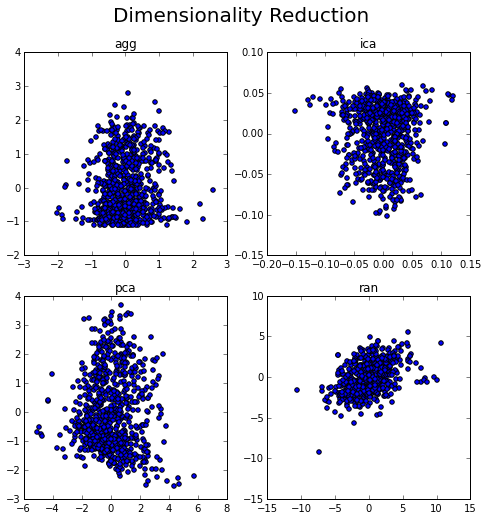

In [11]:
# 2D comparisons
fig, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.reshape(-1)
for i, red in enumerate(dim_red):
    projected_data = dim_red[red][0]
    ax = axes[i]
    ax.scatter(projected_data[:,0], projected_data[:,1])
    ax.set_title("{}".format(red))
fig.suptitle("Dimensionality Reduction", size=20)
fig.savefig("{}/{}_red_plain.png".format(save_dir, dset))
# Reduce to 1D if you have time
# Random seems gaussian
# ICA seems square
# Agglomeration seems the most well distributed
# Note range of random projection explains variance over ICA

In [12]:
# ICA notes
for dim in range(len(models['ica'])):
    print(models['ica'][dim].components_[0])

# Meaningless projections, nothing over .02 (features are normalized)

[ 0.0004697  -0.00851091 -0.00764712 -0.01270713 -0.01211826 -0.01160375
 -0.00731592 -0.00105354]
[-1.64147437e-02 -8.79130169e-03 -4.57282738e-03  7.45570356e-03
  2.78339557e-03  1.74996324e-03 -8.65061464e-05 -1.78953327e-02]
[ 5.99967654e-04 -1.89140542e-03 -4.71289291e-03  2.74523220e-03
  5.41096069e-05  2.17929099e-04  3.55920570e-02  2.25090621e-03]
[ 0.00426202 -0.00366361  0.0029041   0.00357899  0.00325471 -0.00128146
 -0.03584315 -0.00116654]


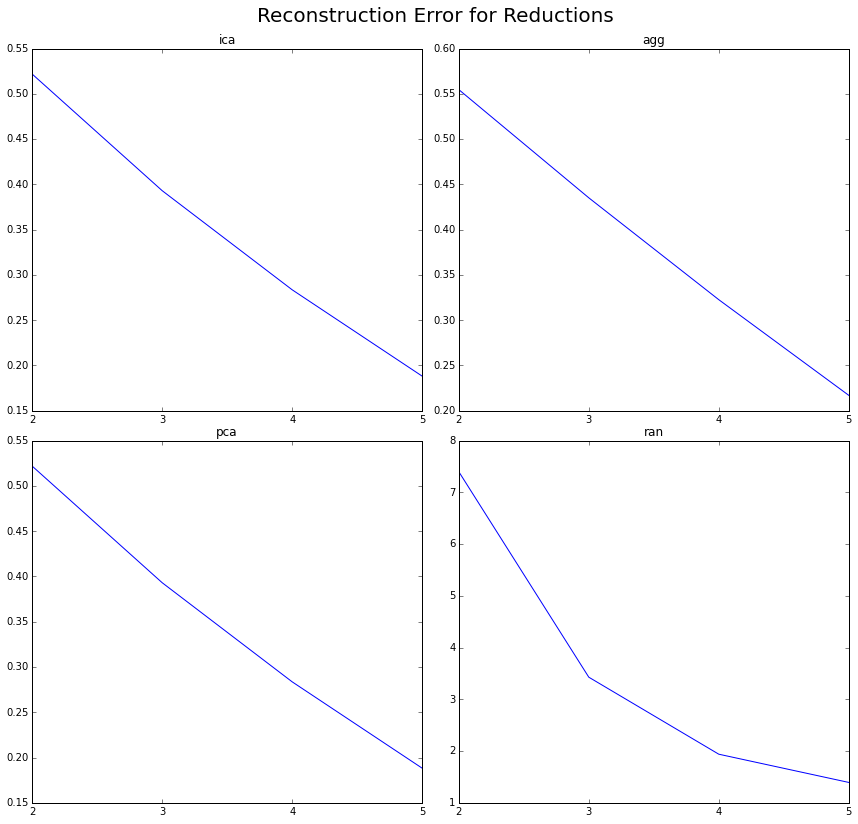

In [13]:
# Reconstruction of initial 2D data (projected down to 2D)
# Unmix and measure SSE
reconstruction_errors = {}
for red in models:
    reconstruction_errors[red] = []
    for i, model in enumerate(models[red]):
#         print(model)
        transformed = dim_red[red][i]
        try: 
            reconstruct = model.inverse_transform(transformed)
        except:
            reconstruct = np.matmul(transformed, model.components_)
        error = ((x - reconstruct)**2).mean()
        reconstruction_errors[red].append(error)

# Graph error
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axes = axes.reshape(-1)
for i, red in enumerate(reconstruction_errors):
    ax = axes[i]
    ax.plot(reconstruction_errors[red])
    ax.set_title("{}".format(red))
    ax.set_xticks(np.arange(len(num_features)))
    ax.set_xticklabels(num_features)
    
fig.suptitle("Reconstruction Error for Reductions", size=20)
fig.savefig("{}/{}_reconstruction_err.png".format(save_dir, dset))
# WHy are ICA and PCA identical?

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


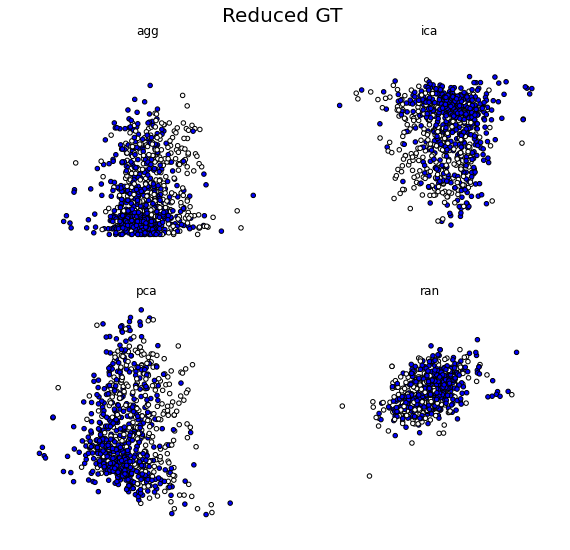

In [14]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axes = axes.reshape(-1)
for i, red in enumerate(dim_red):
    projected_data = dim_red[red][0] # use 2D - 0 index
    ax = axes[i]
    ax.set_axis_off()
    ax.scatter(projected_data[:,0], projected_data[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
    ax.set_title("{}".format(red, j))
fig.suptitle("Reduced GT", size=20)
fig.savefig("{}/{}_red_gt.png".format(save_dir, dset))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


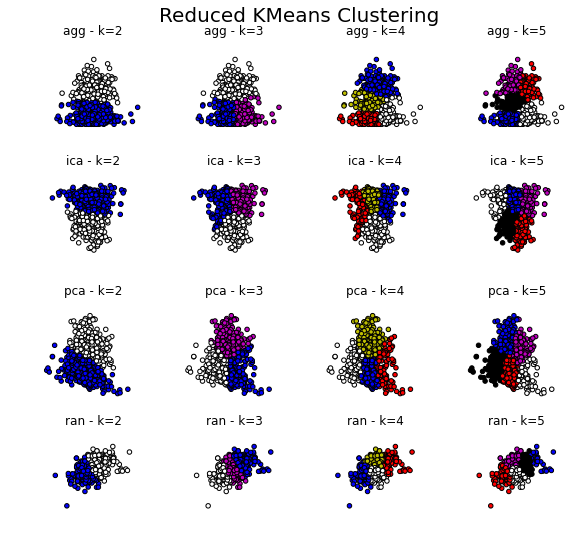

In [27]:
# Clustering on 2D Reductions (Refusing to reduce, cluster, then reduce again)
# 2D comparisons
red_cluster_range=range(2,6)
fig, axes = plt.subplots(4,4, figsize=(8,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

km_cluster_labels = {}
km_silhouettes_red = {}
for i, red in enumerate(dim_red):
    km_cluster_labels[red] = []
    km_silhouettes_red[red] = []
    projected_data = dim_red[red][0] # use 2D - 0 index
    for k, j in enumerate(red_cluster_range):
        model = KMeans(n_clusters=j, random_state=seed).fit(projected_data)
        km_cluster_labels[red].append(model.labels_)
        km_silhouettes_red[red].append(metrics.silhouette_score(projected_data, km_cluster_labels[red][-1], metric='euclidean'))
        ax = axes[i,k]
        ax.set_axis_off()
        ax.scatter(projected_data[:,0], projected_data[:,1], c=model.labels_, cmap=matplotlib.colors.ListedColormap(colors))
        ax.set_title("{} - k={}".format(red, j))
fig.suptitle("Reduced KMeans Clustering", size=20)
fig.savefig("{}/{}_red_km_cluster.png".format(save_dir, dset))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


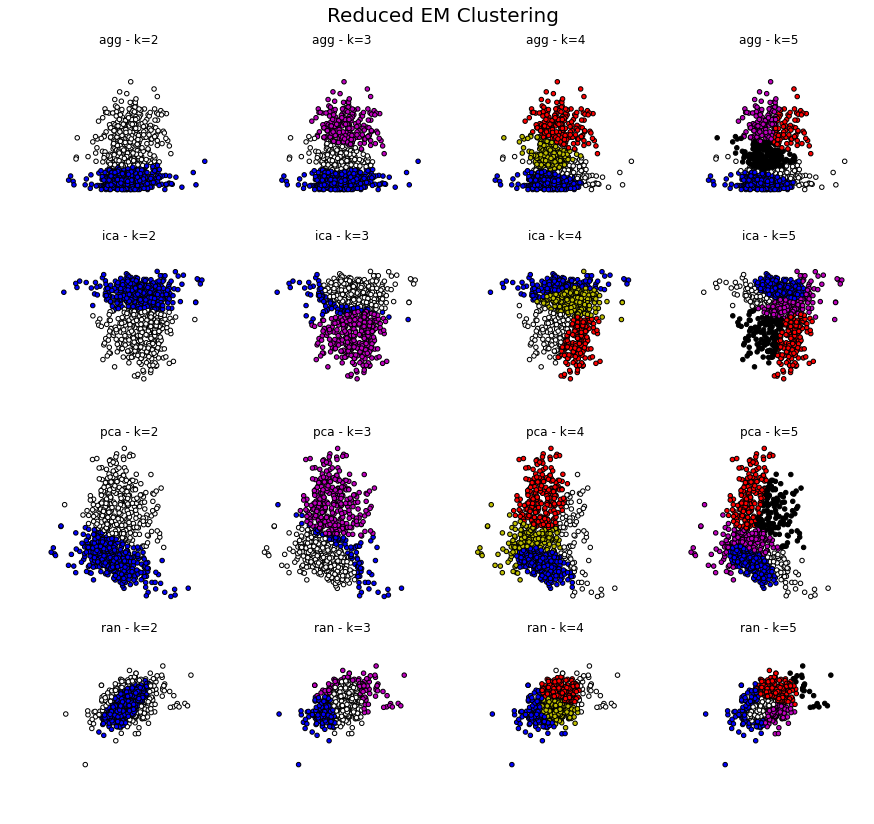

In [29]:
# Clustering on 2D Reductions (Refusing to reduce, cluster, then reduce again)
# 2D comparisons
red_cluster_range=range(2,6)
fig, axes = plt.subplots(4,4, figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

em_cluster_labels = {}
em_silhouettes_red = {}
for i, red in enumerate(dim_red):
    em_cluster_labels[red] = []
    em_silhouettes_red[red] = []
    projected_data = dim_red[red][0] # use 2D - 0 index
    for k, j in enumerate(red_cluster_range):
        model = GaussianMixture(n_components=j, random_state=seed).fit(projected_data)
        em_cluster_labels[red].append(model.predict(projected_data))
        em_silhouettes_red[red].append(metrics.silhouette_score(projected_data, em_cluster_labels[red][-1], metric='euclidean'))
        ax = axes[i,k]
        ax.set_axis_off()
        ax.scatter(projected_data[:,0], projected_data[:,1], c=em_cluster_labels[red][-1], cmap=matplotlib.colors.ListedColormap(colors))
        ax.set_title("{} - k={}".format(red, j))
fig.suptitle("Reduced EM Clustering", size=20)
fig.savefig("{}/{}_red_em_cluster.png".format(save_dir, dset))
# Overall cleaner cuts - this is definitely different from projecting

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


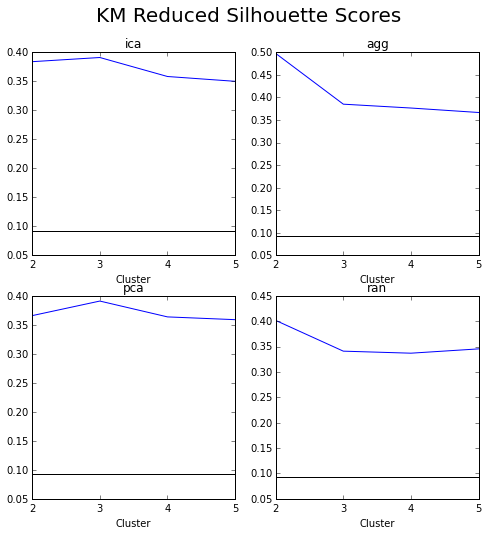

In [46]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
axes = axes.reshape(-1)
for i, red in enumerate(km_silhouettes_red):
    ax = axes[i]
    ax.plot(km_silhouettes_red[red])
    ax.hlines(true_silhouette,0,len(km_silhouettes_red[red]) - 1)
    ax.set_xlabel("Cluster")
    ax.set_xticks(range(len(km_silhouettes_red[red])))
    ax.set_xticklabels(range(2,6))
    ax.set_title("{}".format(red))
fig.suptitle("KM Reduced Silhouette Scores", size=20)
fig.savefig("{}/{}_red_km_silhouette.png".format(save_dir, dset))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


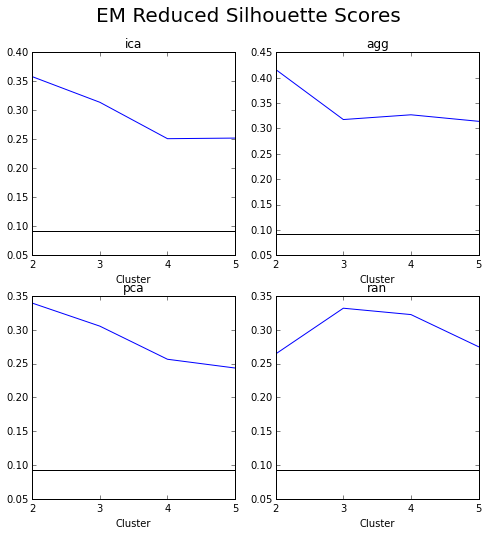

In [45]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
axes = axes.reshape(-1)
for i, red in enumerate(em_silhouettes_red):
    ax = axes[i]
    ax.plot(em_silhouettes_red[red])
    ax.hlines(true_silhouette,0,len(em_silhouettes_red[red]) - 1)
    ax.set_xlabel("Cluster")
    ax.set_xticks(range(len(em_silhouettes_red[red])))
    ax.set_xticklabels(range(2,6))
    ax.set_title("{}".format(red))
fig.suptitle("EM Reduced Silhouette Scores", size=20)
fig.savefig("{}/{}_red_em_silhouette.png".format(save_dir, dset))

In [17]:
# Neural Net: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# Baseline - arch chosen as good one from init experiments, and suitable for low dim
clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                     hidden_layer_sizes=(3, 3), random_state=seed)
accuracy = cross_val_score(clf, x_tr, y_tr, scoring='accuracy', cv=kf)
baseline = accuracy.mean() # Easy graph over number of classes here

In [18]:
# We have dim reduced data in dim_red[red][0-4] 
# We don't expect improvement as data is already low feature
net_acc = {}
for red in dim_red:
    net_acc[red] = []
    for reduced in dim_red[red]:
        net_acc[red].append(cross_val_score(clf, reduced, y, scoring='accuracy', cv=kf).mean())
print(net_acc['ica'])

[0.6519820049231814, 0.7262880909939733, 0.6519820049231814, 0.6519820049231814]


/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


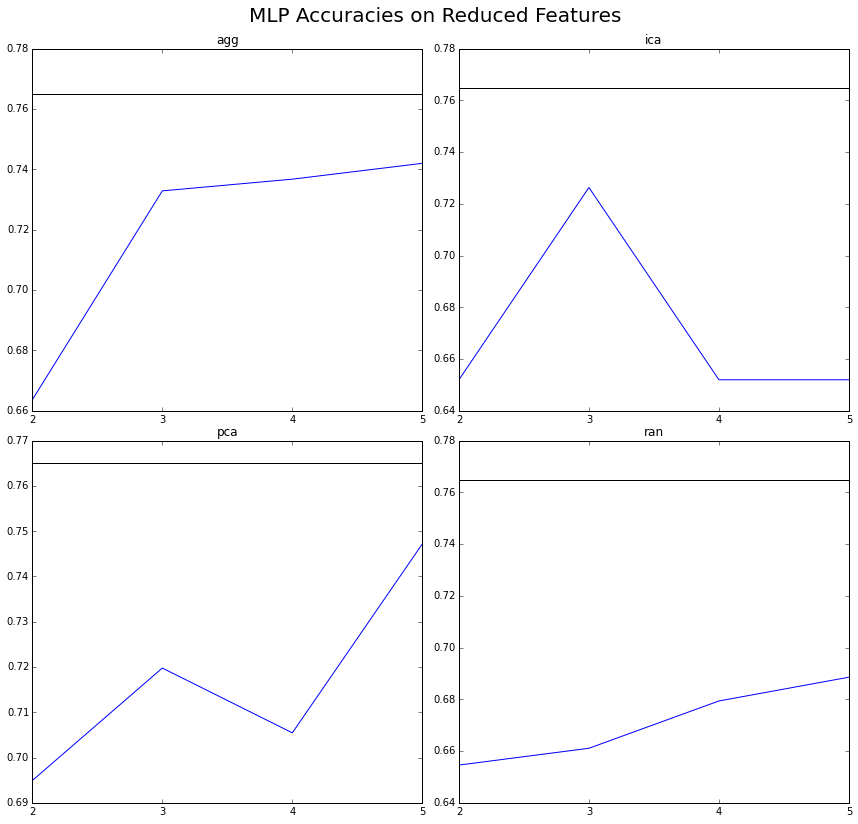

In [19]:
# Classifying on 2D Reductions (Refusing to reduce, cluster, then reduce again)
# 2D comparisons
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axes = axes.reshape(-1)
for i, red in enumerate(dim_red):
    ax = axes[i]
    ax.plot(net_acc[red])
    ax.set_title("{}".format(red))
    ax.set_xticks(np.arange(len(num_features)))
    ax.set_xticklabels(num_features)
    ax.hlines(baseline,0,len(num_features) - 1)
    
fig.suptitle("MLP Accuracies on Reduced Features", size=20)
fig.savefig("{}/{}_red_net_acc.png".format(save_dir, dset))

In [20]:
# Stored in cluster_labels
net_acc_cluster_only = {}
net_acc_cluster_only['km'] = {}
net_acc_cluster_only['em'] = {}
for red in km_cluster_labels:
    net_acc_cluster_only['km'][red] = []
    for label in km_cluster_labels[red]:
        net_acc_cluster_only['km'][red].append(cross_val_score(clf, label[:, np.newaxis], y, scoring='accuracy', cv=kf).mean())
        
for red in em_cluster_labels:
    net_acc_cluster_only['em'][red] = []
    for label in em_cluster_labels[red]:
        net_acc_cluster_only['em'][red].append(cross_val_score(clf, label[:, np.newaxis], y, scoring='accuracy', cv=kf).mean())

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


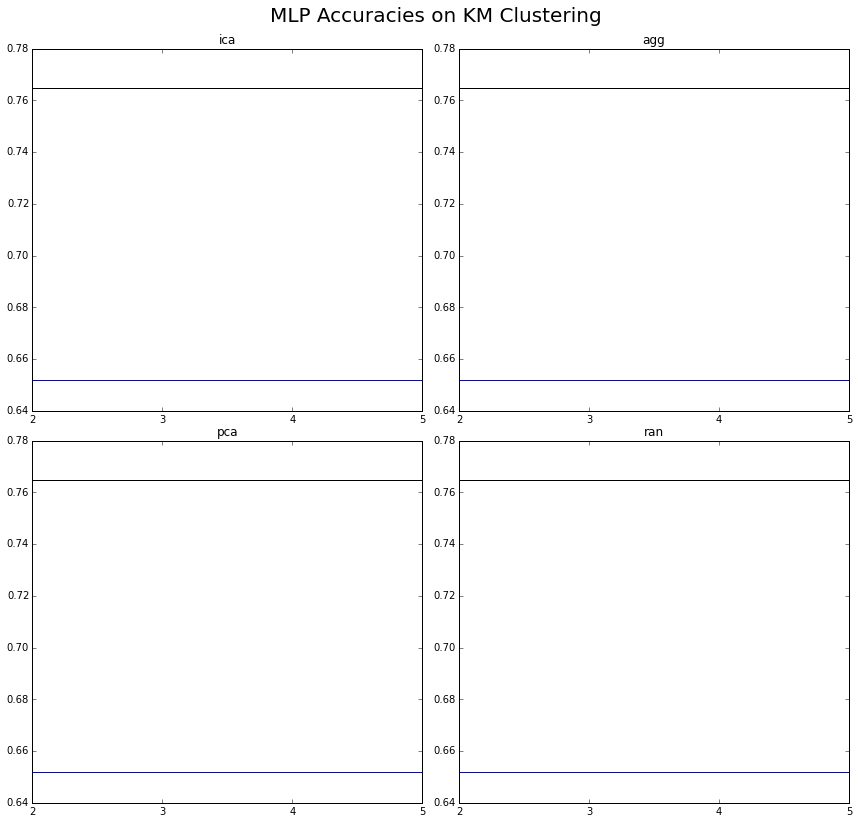

In [21]:
# Clustering on 2D Reductions (Refusing to reduce, cluster, then reduce again)
# 2D comparisons
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axes = axes.reshape(-1)
for i, red in enumerate(km_cluster_labels):
    ax = axes[i]
    ax.plot(net_acc_cluster_only['km'][red])
    ax.set_title("{}".format(red))
    ax.set_xticks(np.arange(len(red_cluster_range)))
    ax.set_xticklabels(red_cluster_range)
    ax.hlines(baseline,0,len(red_cluster_range) - 1)
    
fig.suptitle("MLP Accuracies on KM Clustering", size=20)
fig.savefig("{}/{}_km_only_net_acc.png".format(save_dir, dset))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


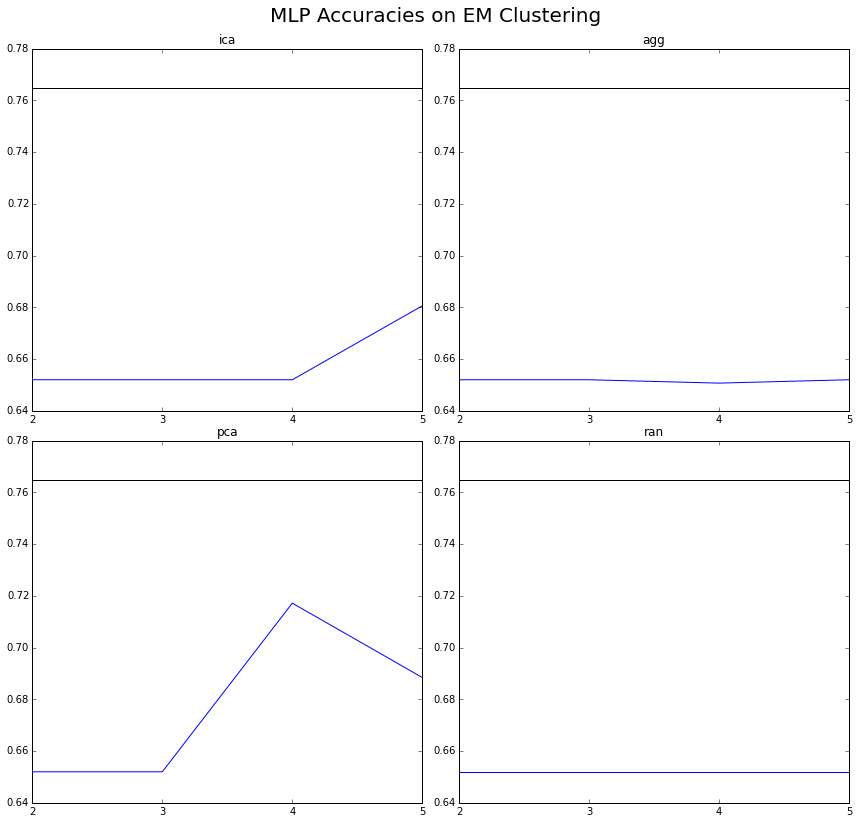

In [22]:
# Clustering on 2D Reductions (Refusing to reduce, cluster, then reduce again)
# 2D comparisons
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axes = axes.reshape(-1)
for i, red in enumerate(em_cluster_labels):
    ax = axes[i]
    ax.plot(net_acc_cluster_only['em'][red])
    ax.set_title("{}".format(red))
    ax.set_xticks(np.arange(len(red_cluster_range)))
    ax.set_xticklabels(red_cluster_range)
    ax.hlines(baseline,0,len(red_cluster_range) - 1)
    
fig.suptitle("MLP Accuracies on EM Clustering", size=20)
fig.savefig("{}/{}_em_only_net_acc.png".format(save_dir, dset))

In [23]:
# Stored in cluster_labels
net_acc_cluster_add = {}
net_acc_cluster_add['km'] = {}
net_acc_cluster_add['em'] = {}
for red in km_cluster_labels:
    net_acc_cluster_add['km'][red] = []
    for label in km_cluster_labels[red]:
        label_feat = label[:, np.newaxis]
        aug_x  = np.concatenate((x, label_feat), axis=1)
        net_acc_cluster_add['km'][red].append(cross_val_score(clf, aug_x, y, scoring='accuracy', cv=kf).mean())
        
for red in em_cluster_labels:
    net_acc_cluster_add['em'][red] = []
    for label in em_cluster_labels[red]:
        label_feat = label[:, np.newaxis]
        aug_x  = np.concatenate((x, label_feat), axis=1)
        net_acc_cluster_add['em'][red].append(cross_val_score(clf, aug_x, y, scoring='accuracy', cv=kf).mean())

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


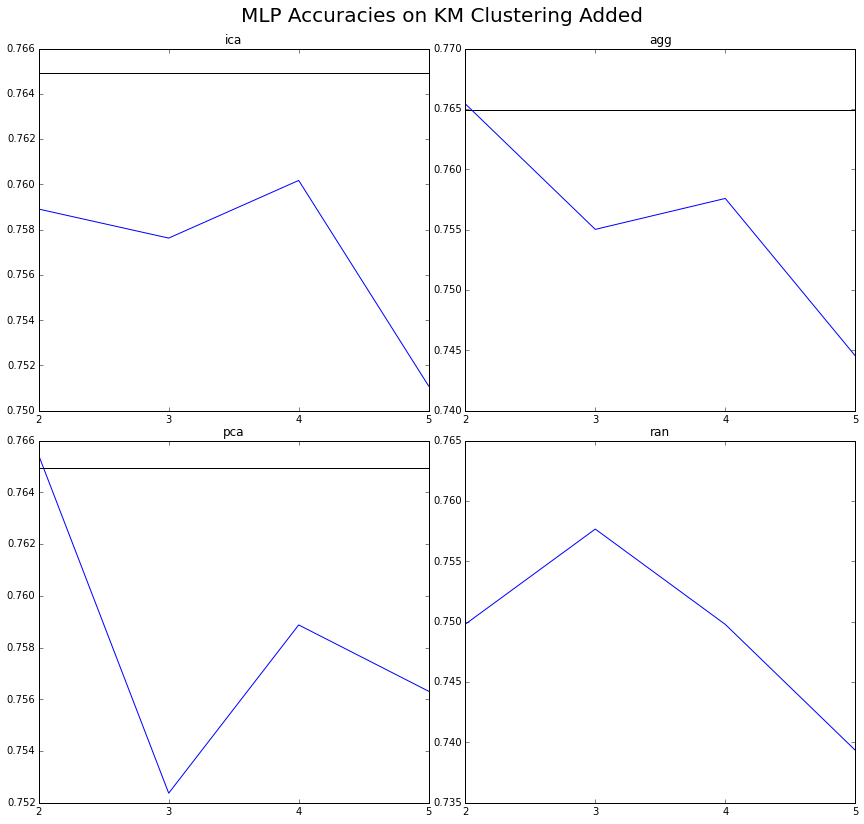

In [24]:
# Clustering on 2D Reductions (Refusing to reduce, cluster, then reduce again)
# 2D comparisons
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axes = axes.reshape(-1)
for i, red in enumerate(km_cluster_labels):
    ax = axes[i]
    ax.plot(net_acc_cluster_add['km'][red])
    ax.set_title("{}".format(red))
    ax.set_xticks(np.arange(len(red_cluster_range)))
    ax.set_xticklabels(red_cluster_range)
    ax.hlines(baseline,0,len(red_cluster_range) - 1)
    
fig.suptitle("MLP Accuracies on KM Clustering Added", size=20)
fig.savefig("{}/{}_km_add_net_acc.png".format(save_dir, dset))

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


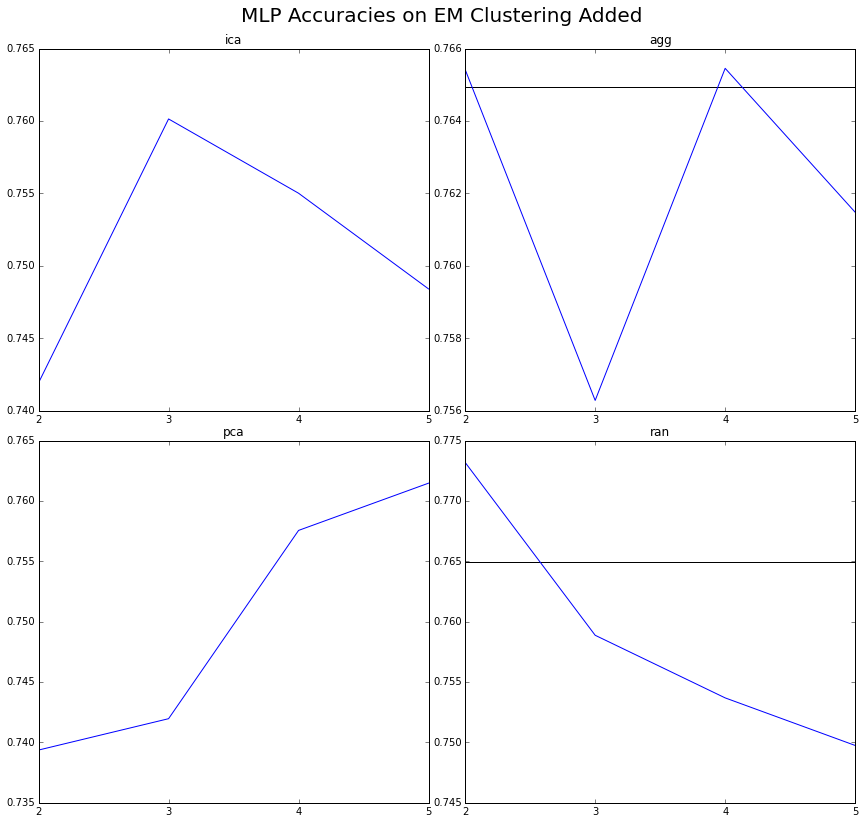

In [25]:
# Clustering on 2D Reductions (Refusing to reduce, cluster, then reduce again)
# 2D comparisons
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axes = axes.reshape(-1)
for i, red in enumerate(em_cluster_labels):
    ax = axes[i]
    ax.plot(net_acc_cluster_add['em'][red])
    ax.set_title("{}".format(red))
    ax.set_xticks(np.arange(len(red_cluster_range)))
    ax.set_xticklabels(red_cluster_range)
    ax.hlines(baseline,0,len(red_cluster_range) - 1)
    
fig.suptitle("MLP Accuracies on EM Clustering Added", size=20)
fig.savefig("{}/{}_em_add_net_acc.png".format(save_dir, dset))